<a href="https://colab.research.google.com/github/vblagoje/notebooks/blob/main/haystack2x-experiments/agentic_rag_pipeline_with_memory_and_chat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Agentic RAG Pipeline with memory and chat

_notebook by Stefano Fiorucci ([Twitter](https://x.com/theanakin87), [LI](https://www.linkedin.com/in/stefano-fiorucci/)), Bilge Yucel ([Twitter](https://x.com/bilgeycl), [LI](https://www.linkedin.com/in/bilge-yucel/)),  and Tilde Thurium ([Twitter](https://x.com/annthurium), [LI](https://www.linkedin.com/in/annthurium/))_

Here is an agentic RAG pipelines that can remember previous chat messages. The most helpful assistants don't forget the thing you just said. 📓

This pipeline takes advantage of Haystack's flexible looping capabilities, running and saving previous interactions until you exit.

Components used:
- [`InMemoryDocumentStore`](https://docs.haystack.deepset.ai/docs/inmemorydocumentstore)
- [`InMemoryBM25Retriever`](https://docs.haystack.deepset.ai/docs/inmemorybm25retriever)
- [`ChatPromptBuilder`](https://docs.haystack.deepset.ai/docs/chatpromptbuilder)
- [`FilterRetriever`](https://docs.haystack.deepset.ai/docs/filterretriever)
- [`DocumentWriter`](https://docs.haystack.deepset.ai/docs/documentwriter)
- [`OutputAdapter`](https://docs.haystack.deepset.ai/docs/outputadapter)

### Prerequisites

You'll need an [OpenAI API Key](https://help.openai.com/en/articles/4936850-where-do-i-find-my-openai-api-key), although this code could be adapted to use [any model Haystack supports](https://docs.haystack.deepset.ai/docs/generators).

## Installation

In [1]:
%%bash

pip install haystack-ai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.2/345.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.1 MB/s eta 0:00:00


## Authorization

In [2]:
import os
from getpass import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

Enter OpenAI API key:··········


## Initialize the document store

Write some documents to the `DocumentStore`. You'll ask the agent to refer to them later.

In [66]:
from haystack import Document, Pipeline
from haystack.components.builders.chat_prompt_builder import ChatPromptBuilder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.dataclasses import ChatMessage
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()
documents = [Document(content="There are over 7,000 languages spoken around the world today."),
             Document(content="Chinese language boasts the highest number of native speakers."),
			       Document(content="Elephants have been observed to behave in a way that indicates a high level of self-awareness, such as recognizing themselves in mirrors."),
			       Document(content="In certain parts of the world, like the Maldives, Puerto Rico, and San Diego, you can witness the phenomenon of bioluminescent waves.")]
document_store.write_documents(documents=documents)

4

## Retrieve previous chat messages

`FilterRetriever` is a special retriever that retrieves documents based on the passed-in `filters` parameter. Here, it is used to retrieve documents that were previously stored in the `InMemoryDocumentStore`.

Note that no filters are passed in to the `FilterRetriever`. If we had a huge list of chat messages, this could get quite slow! In a production scenario, you'd want to create a session ID for each chat session and pass that in as a filter.

In [67]:
from haystack.components.retrievers import FilterRetriever
from haystack.components.writers import DocumentWriter
from haystack import Document
from haystack.components.converters import OutputAdapter
from typing import List
from haystack.document_stores.types import DuplicatePolicy

memory_store = InMemoryDocumentStore()
memory_retriever = FilterRetriever(memory_store)
# The same ChatMessage can't be stored multiple times in memory_store
memory_writer = DocumentWriter(memory_store, policy=DuplicatePolicy.SKIP)

## Save `ChatMessage` objects

As the pipeline runs through multiple loops, you'll need to save previous chat messages to the document store.

This is a utility function that takes a list of `ChatMessage` objects and turns them into Haystack documents. The `OutputAdapter` component makes the `chat_messages_to_docs` function fit smoothly into our pipeline, passing the input from the component at the end of the previous loop iteration into the next.

In [68]:
def chat_messages_to_docs(chat_messages: List[ChatMessage], question: str):
    # return user's question and LLM response(s) as Documents
    return [Document(content=question)] + [Document(content=message.content) for message in chat_messages]

output_adapter = OutputAdapter(template="{{ chat_messages | chat_messages_to_docs(question) }}", output_type=List[Document], custom_filters={"chat_messages_to_docs": chat_messages_to_docs})

## Create the prompt

The system message tells the LLM how to act.

We need 2 loops here in our prompt: one to run through the memories, one to run through any relevant documents that were returned.

For simplicity, this pipelines uses the `InMemoryBM25Retriever` to do keyword-based retrieval. In a production scenario where you're searching a vast number of documents, an `EmbeddingRetriever` would be faster and more accurate.

The `PromptBuilder` will take 3 arguments when the pipeline is run:
- _query_, the chat message from the current loop iteration
- _documents_, which were written when we initialized the `DocumentStore`
- _memories_, or previous chat messages

In [69]:
system_message = ChatMessage.from_system("You are a helpful assistant with chat history and ability to recall previous conversation")
user_message_template ="""
    Chat history is a transcript of a user/assistant interactions so far. Documents are provided for RAG support but don't represent ongoing conversation.

    Chat history:
    {% for memory in memories %}
        {{ memory.content }}
    {% endfor %}

    Documents:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    Given the chat history and the provided documents, answer the question.
    \nQuestion: {{query}}
    \nAnswer:
"""
user_message = ChatMessage.from_user(user_message_template)

## Create the pipeline

In [70]:
# components for RAG
pipeline = Pipeline()
pipeline.add_component("retriever", InMemoryBM25Retriever(document_store=document_store))
pipeline.add_component("prompt_builder", ChatPromptBuilder(template=[system_message, user_message]))
pipeline.add_component("llm", OpenAIChatGenerator(model="gpt-4"))

# components for memory
pipeline.add_component("memory_retriever", memory_retriever)
pipeline.add_component("memory_writer", memory_writer)
pipeline.add_component("output_adapter", output_adapter)

# connections for RAG
pipeline.connect("retriever.documents", "prompt_builder.documents")
pipeline.connect("prompt_builder.prompt", "llm.messages")

# connections for memory
pipeline.connect("memory_retriever", "prompt_builder.memories")
pipeline.connect("llm.replies", "output_adapter.chat_messages")
pipeline.connect("output_adapter", "memory_writer")

🚅 Components
  - retriever: InMemoryBM25Retriever
  - prompt_builder: ChatPromptBuilder
  - llm: OpenAIChatGenerator
  - memory_retriever: FilterRetriever
  - memory_writer: DocumentWriter
  - output_adapter: OutputAdapter
🛤️ Connections
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.messages (List[ChatMessage])
  - llm.replies -> output_adapter.chat_messages (List[ChatMessage])
  - memory_retriever.documents -> prompt_builder.memories (List[Document])
  - output_adapter.output -> memory_writer.documents (List[Document])

## Visualize the pipeline

If you want to see a diagram of the pipeline, running this cell will create a file locally. https://docs.haystack.deepset.ai/docs/visualizing-pipelines

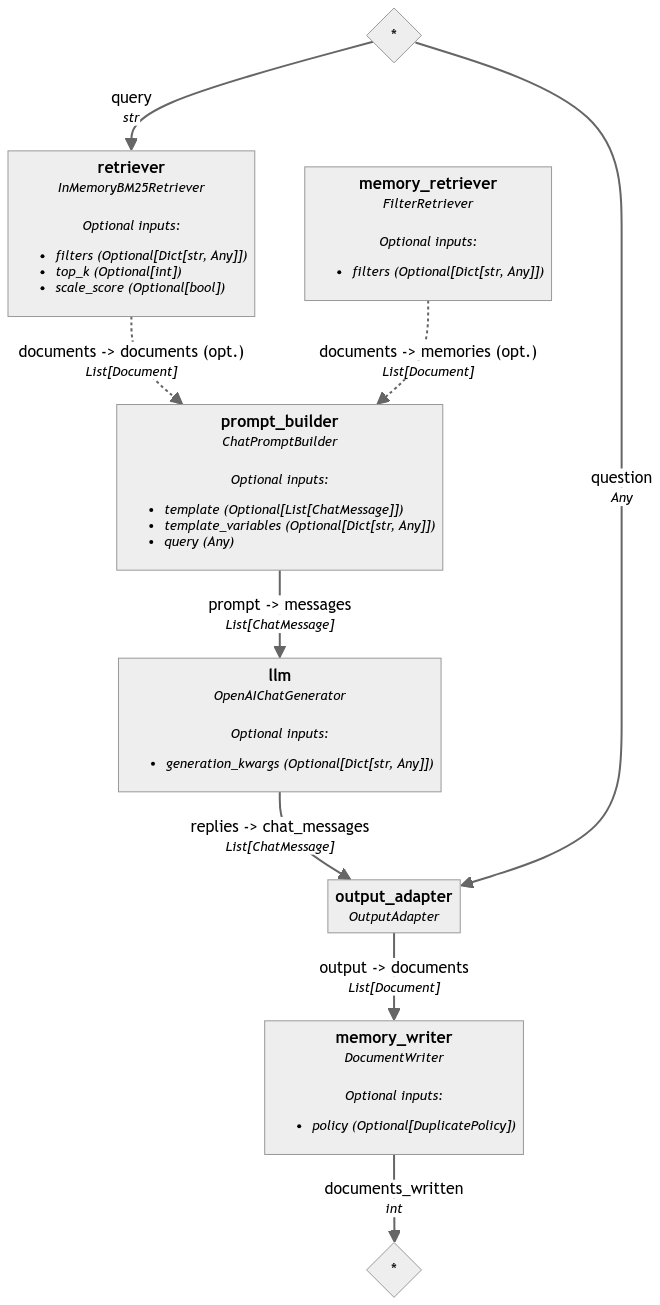

In [71]:
pipeline.show()

# Bring it all together

What follows is glue code to run the pipeline in a loop, provide input instructions, and break when the user enters `Q` to quit.

Here are some example questions to get you started:
- _How many languages are there?_
- _What is the one with most native speakers?_
- _What questions have I asked you already?_
- _Tell me a cool fact about elephants?_
- _What topics have we talked about so far?_

In [72]:
while True:
    question = input("Enter your question or Q to exit. Example: How many languages are there?\n🔮 ")
    if question=="Q":
        break

    res = pipeline.run(data={"retriever": {"query": question},
                             "output_adapter" : {"question": question},
                             "prompt_builder": {"template_variables": {"query": question}}}, include_outputs_from={"llm", "memory_retriever"})
    print(f"res: {res}")
    assistant_resp = res['llm']['replies'][0]
    print(f"🤖 {assistant_resp.content}")

Enter your question or Q to exit. Example: How many languages are there?
🔮 How many languages are there?


res: {'memory_writer': {'documents_written': 0}, 'llm': {'replies': [ChatMessage(content='There are over 7,000 languages spoken around the world today.', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4-0613', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 14, 'prompt_tokens': 205, 'total_tokens': 219}})]}, 'memory_retriever': {'documents': [Document(id=789414006f3b229ce12aa9cfff5decc0c3a72e7865d9addc51c76e0a6176dd51, content: 'How many languages are there?'), Document(id=cfe93bc1c274908801e6670440bf2bbba54fad792770d57421f85ffa2a4fcc94, content: 'There are over 7,000 languages spoken around the world today.')]}}
🤖 There are over 7,000 languages spoken around the world today.
Enter your question or Q to exit. Example: How many languages are there?
🔮 What is the one with most native speakers?


res: {'memory_writer': {'documents_written': 0}, 'llm': {'replies': [ChatMessage(content='The Chinese language has the most native speakers.', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4-0613', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 9, 'prompt_tokens': 230, 'total_tokens': 239}})]}, 'memory_retriever': {'documents': [Document(id=789414006f3b229ce12aa9cfff5decc0c3a72e7865d9addc51c76e0a6176dd51, content: 'How many languages are there?'), Document(id=cfe93bc1c274908801e6670440bf2bbba54fad792770d57421f85ffa2a4fcc94, content: 'There are over 7,000 languages spoken around the world today.'), Document(id=c9f2f8cb4e7c92cf1c10fbf8eb5eb13dd4a6b7a1a147a8729806894555d4efd6, content: 'What is the one with most native speakers?'), Document(id=ae9440968ac833ad81dea0ae8bd7c4120f477da81e88c26b72770ec455c3ea33, content: 'The Chinese language has the most native speakers.')]}}
🤖 The Chinese language has the most native speakers.
Enter your questio

res: {'memory_writer': {'documents_written': 1}, 'llm': {'replies': [ChatMessage(content='You have asked two questions so far: "How many languages are there?" and "What is the one with most native speakers?"', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4-0613', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 26, 'prompt_tokens': 252, 'total_tokens': 278}})]}, 'memory_retriever': {'documents': [Document(id=789414006f3b229ce12aa9cfff5decc0c3a72e7865d9addc51c76e0a6176dd51, content: 'How many languages are there?'), Document(id=cfe93bc1c274908801e6670440bf2bbba54fad792770d57421f85ffa2a4fcc94, content: 'There are over 7,000 languages spoken around the world today.'), Document(id=c9f2f8cb4e7c92cf1c10fbf8eb5eb13dd4a6b7a1a147a8729806894555d4efd6, content: 'What is the one with most native speakers?'), Document(id=ae9440968ac833ad81dea0ae8bd7c4120f477da81e88c26b72770ec455c3ea33, content: 'The Chinese language has the most native speakers.'), Docum

res: {'memory_writer': {'documents_written': 0}, 'llm': {'replies': [ChatMessage(content='Elephants have been observed to behave in a way that indicates a high level of self-awareness, such as recognizing themselves in mirrors.', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4-0613', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 27, 'prompt_tokens': 319, 'total_tokens': 346}})]}, 'memory_retriever': {'documents': [Document(id=789414006f3b229ce12aa9cfff5decc0c3a72e7865d9addc51c76e0a6176dd51, content: 'How many languages are there?'), Document(id=cfe93bc1c274908801e6670440bf2bbba54fad792770d57421f85ffa2a4fcc94, content: 'There are over 7,000 languages spoken around the world today.'), Document(id=c9f2f8cb4e7c92cf1c10fbf8eb5eb13dd4a6b7a1a147a8729806894555d4efd6, content: 'What is the one with most native speakers?'), Document(id=ae9440968ac833ad81dea0ae8bd7c4120f477da81e88c26b72770ec455c3ea33, content: 'The Chinese language has the most nativ

res: {'memory_writer': {'documents_written': 1}, 'llm': {'replies': [ChatMessage(content='We have talked about the total number of languages spoken globally, the language with the most native speakers, and a unique fact about elephants.', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4-0613', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 27, 'prompt_tokens': 348, 'total_tokens': 375}})]}, 'memory_retriever': {'documents': [Document(id=789414006f3b229ce12aa9cfff5decc0c3a72e7865d9addc51c76e0a6176dd51, content: 'How many languages are there?'), Document(id=cfe93bc1c274908801e6670440bf2bbba54fad792770d57421f85ffa2a4fcc94, content: 'There are over 7,000 languages spoken around the world today.'), Document(id=c9f2f8cb4e7c92cf1c10fbf8eb5eb13dd4a6b7a1a147a8729806894555d4efd6, content: 'What is the one with most native speakers?'), Document(id=ae9440968ac833ad81dea0ae8bd7c4120f477da81e88c26b72770ec455c3ea33, content: 'The Chinese language has the m

KeyboardInterrupt: Interrupted by user